### import libraries

In [9]:
import os
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import datetime

### Load and preprocess data

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = self._load_images()

    def _load_images(self):
        images = []
        labels = []
        class_names = sorted(os.listdir(self.root_dir))
        
        for label, class_name in enumerate(class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg')):
                        images.append(os.path.join(class_dir, img_name))
                        labels.append(label)
        
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_root_dir = './dataset/dataset/train'
trainset = ImageDataset(root_dir = train_root_dir, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True)

test_root_dir = './dataset/dataset/test'
testset = ImageDataset(root_dir = test_root_dir, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

# Define class names
classes = ('adult', 'child')

### visualize the data

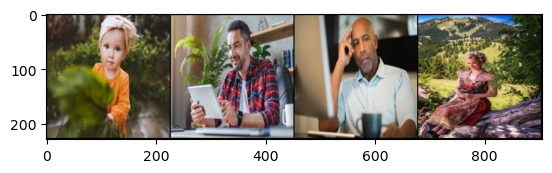

child adult adult adult


In [4]:
# Function to display images
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### define CNN

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # pic size origin = 370*320
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### define loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train the model

In [16]:
num_epochs = 50
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'Epoch{epoch + 1}, Loss: {running_loss/len(trainloader)}')

print('Finished Training')

Epoch1, Loss: 0.00011038621937737858
Epoch2, Loss: 0.0001054965942083668
Epoch3, Loss: 0.00010115415224833311
Epoch4, Loss: 9.67170266128343e-05
Epoch5, Loss: 9.295426721331879e-05
Epoch6, Loss: 8.93591173687496e-05
Epoch7, Loss: 8.591387843189325e-05
Epoch8, Loss: 8.28166062909982e-05
Epoch9, Loss: 7.994472598144802e-05
Epoch10, Loss: 7.73802799743452e-05
Epoch11, Loss: 7.467232725920172e-05
Epoch12, Loss: 7.230054649609891e-05
Epoch13, Loss: 7.022040338009461e-05
Epoch14, Loss: 6.783827013577033e-05
Epoch15, Loss: 6.612027549652209e-05
Epoch16, Loss: 6.410790940367356e-05
Epoch17, Loss: 6.227893515838697e-05
Epoch18, Loss: 6.0526476112597396e-05
Epoch19, Loss: 5.9095383212578616e-05
Epoch20, Loss: 5.7502155526772165e-05
Epoch21, Loss: 5.611119253530512e-05
Epoch22, Loss: 5.4739671383684046e-05
Epoch23, Loss: 5.3459362197903564e-05
Epoch24, Loss: 5.2212844184802114e-05
Epoch25, Loss: 5.0934131481180805e-05
Epoch26, Loss: 4.9830656655761425e-05
Epoch27, Loss: 4.867418273281235e-05
Epoc

### save the model

In [13]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_base_name = '2_layer_cnn'
file_extension = '.pth'
model_file_name = f"./models/{model_base_name}_{timestamp}{file_extension}"

torch.save(net.state_dict(), model_file_name)

### evaluate the model

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 60.0 %


### view the result

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]} %')

Accuracy of adult : 55.0 %
Accuracy of child : 65.0 %
